In [446]:
import numpy as np
import matplotlib.pyplot as plt
import json, pandas as pd, glob, tqdm
import gzip

def label(line, label, idx=-1, dx=0, **kwargs):
    if isinstance(line, list): line = line[0]
    x, y = line.get_data()
    plt.text(
        x[idx]+dx,
        y[idx],
        label,
        **kwargs, color=line.get_color())
    

plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.directory'] = '.'
plt.rcParams['font.size'] = 16


# One

In [447]:
glob.glob?

Signature: glob.glob(pathname, *, root_dir=None, dir_fd=None, recursive=False)
Docstring:
Return a list of paths matching a pathname pattern.

The pattern may contain simple shell-style wildcards a la
fnmatch. However, unlike fnmatch, filenames starting with a
dot are special cases that are not matched by '*' and '?'
patterns.

If recursive is true, the pattern '**' will match any files and
zero or more directories and subdirectories.
File:      /usr/lib/python3.10/glob.py
Type:      function


In [448]:
!pwd

tables = {}

for f in tqdm.tqdm(glob.glob('saved/*/log.jsons*')):
    args, hparams = {}, {}
    handle = gzip.open(f, 'rt') if f.endswith('.gz') else open(f)
    try:
        with handle as fh:
            for l in fh:
                j = json.loads(l)
                t = j.pop('table')
                if t == 'args': args = j
                elif t == 'hyperparams': hparams = j
                elif t == 'epoch':
                    j.update(args)
                    j.update(hparams)
                    tables.setdefault(t, []).append(j)
    except Exception as ex:
        print()
        print(repr(ex))
        print(f)
        print()

dfs = {t: pd.DataFrame(v) for t, v in tables.items()}
epoch = dfs['epoch']


epoch['plotdim'] = epoch.apply(lambda x:
                               6 if x.netspec == 'inf' else x['ndim'], 1)

final = epoch[(epoch.i == 29) & (epoch.dt == 0.5)]
final = final[final.tgtfreq == 10]

/home/llandsmeer/repos/llandsmeer/spatial_delays


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:32<00:00, 40.40it/s]


0
∞
2
3


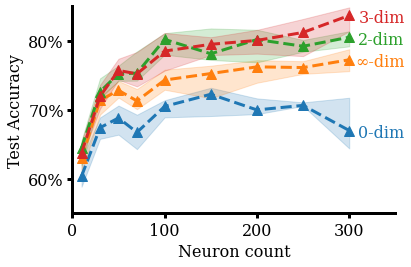

In [449]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    plt.tight_layout()
    plt.savefig(f'img/{net}-dim.svg')
    plt.savefig(f'img/{net}-dim.png', dpi=300)

#plt.legend(title='Network Dimensions', ncol=2)
plt.show()

In [464]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal

ERR = False



plt.xlabel('Neuron count')
if ERR:
    plt.ylim([0, 50])
    plt.ylabel('Test Error')
else:
    plt.ylabel('Test Accuracy')
    plt.ylim([55, 85])
    plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
plt.xticks([0, 100, 200, 300])
plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    if ERR: y = 100 - y
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    line,  = plt.plot(sub.index, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        sub.index.values[-1]+60,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='right',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-dim.svg')
plt.savefig(f'img/nofill-dim.png', dpi=300)

0
∞
2
3


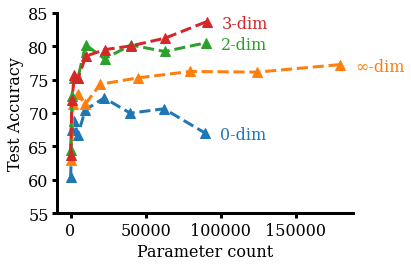

In [473]:
take = [
    '0', 'inf', '2', '3'
    ]

finalnormal = final[final.net.isin(take)]

finalnormal


plt.xlabel('Parameter count')
plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
# plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])
# plt.xticks([0, 100, 200, 300])
# plt.xlim([0, 350])




# for net, sub in finalnormal.groupby('netspec'):
for net in take:
    sub = finalnormal[finalnormal.netspec == net]
    sub = sub.sort_values('nhidden') # type: ignore
    low = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.25)
    high = sub[['nhidden', 't1p']].groupby('nhidden').quantile(0.75)
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    y = sub.t1p
    color = None
    # if net == '0': color = 'black'
    # elif net == 'inf': color = 'blue'
    neurons = sub.index.values
    if net == '0':
        params = neurons * (neurons - 1)
    elif net == 'inf':
        params = 2 * neurons * (neurons - 1)
    else:
        params = neurons * (neurons - 1) + neurons * int(net)
    line,  = plt.plot(params, y, '^--', label=net, color=color)
    net = net.replace('inf', '∞')
    plt.text(
        params[-1]+10000,
        y.values[-1] - 0.3,
        f'{net}-dim',
        va='center',
        ha='left',
        color=line.get_color()
    )
    print(net)
    
plt.tight_layout()
plt.savefig(f'img/nofill-params-dim.svg')
plt.savefig(f'img/nofill-params-dim.png', dpi=300)

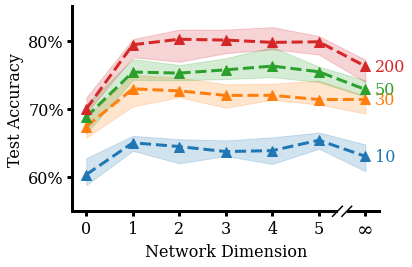

In [450]:
import matplotlib.transforms as mtrans

take = [
    '0', '1', '2', '3', '4', '5', 'inf'
    ]
ax = plt.gca()

finalnormal = final[final.net.isin(take)]

take_nh = [ 10, 30, 50, 200 ]

plt.ylabel('Test Accuracy')
plt.ylim([55, 85])
plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

ticks = [0, 1, 2, 3, 4, 5, 6]
labels = [0, 1, 2, 3, 4, 5, '∞']
ax.set_xticks(ticks)
text_labels = ax.set_xticklabels(labels)

text_labels[-1].set_fontsize(20)

for nh, sub in finalnormal.groupby('nhidden'):
    if take_nh and nh not in take_nh: continue
    sub = sub.sort_values('plotdim')
    low = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.25)
    high = sub[['plotdim', 't1p']].groupby('plotdim').quantile(0.75)
    sub = sub[['plotdim', 't1p']].groupby('plotdim').median()
    line,  = plt.plot(sub.index, sub.t1p, '^--')
    plt.fill_between(sub.index, low.t1p, high.t1p, color=line.get_color(), alpha=0.2)
    plt.text(
        sub.index.values[-1]+0.2,
        sub.t1p.values[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

plt.gcf().canvas.draw()
x_positions = [5.4, 5.6]
y_data = ax.get_ylim()[0]
L_px = 15.0
half = L_px / 2.0
d = half / np.sqrt(2.0)
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
to_display = ax.transData.transform
to_data = ax.transData.inverted().transform
ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
for x0 in x_positions:
    x_disp, y_disp = to_display((x0, y_data))
    p1_disp = (x_disp - d, y_disp - d)
    p2_disp = (x_disp + d, y_disp + d)
    p1_data = to_data(p1_disp)
    p2_data = to_data(p2_disp)
    ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
            color='k', linewidth=1.5, clip_on=False, zorder=100)
plt.xlabel('Network Dimension')
plt.tight_layout()
plt.savefig('img/netw.svg')
plt.savefig('img/netw.png')
plt.show()

# Eps

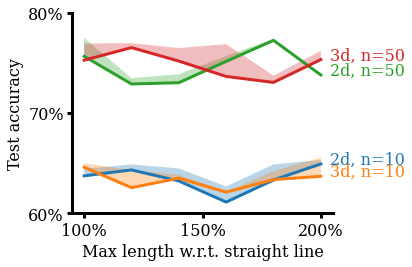

In [451]:
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'plotdim', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'plotdim', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:
for n in [10, 50]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    for d in [2, 3]:
        label(plt.plot(
            100+100*X[X.plotdim==d].eps,
            X[X.plotdim==d].t1p,
            '-'),
            f'{d}d, n={n}', dx=4)
        plt.fill_between(
            100+100*X[X.plotdim==d].eps.values,
            L[L.plotdim==d].t1p.values,
            H[H.plotdim==d].t1p.values, alpha=0.3, zorder=-100)
        
ml = np.array([100, 150, 200])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.tight_layout()
plt.savefig('img/eps.svg')
plt.savefig('img/eps.png')


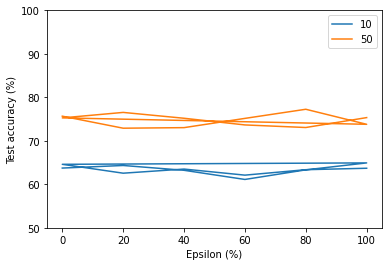

0.0
0.2
0.4
0.6
0.8
1.0


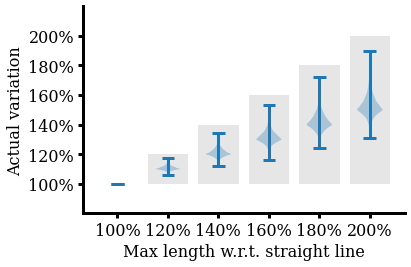

In [452]:
finaleps
finaleps = (epoch[(epoch.i == 49) & (epoch.tag == 'fixed-eps')]).copy()
finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]

dd = dict()
for _idx, row in finaleps.iterrows():
    fns = glob.glob(f'saved/*{row.id}*/epoch_*049.npz')
    if not fns:
        continue
    if row.plotdim != 2:
        continue
    fn, = fns
    d = np.load(fn)
    ieps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['ierr']))
    reps = 100 + 100 * row.eps * (0.5 + 0.5 * np.tanh(d['rerr']))
    if row.eps not in dd:
        dd[row.eps] = []
    dd[row.eps].extend(reps)
    
plt.bar(
    np.arange(1, len(dd)+1),
    100*np.array(sorted(dd.keys())),
    bottom=100,
    color='0.9')

plt.violinplot(
    [dd[k] for k in sorted(dd.keys())]
);

for i, k in enumerate(sorted(dd.keys()), 1):
    print(k)

plt.xticks(np.arange(1, len(dd)+1), [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])
# plt.yticks([100, 150, 200], ['100', '150%', '200%'])
plt.yticks([100+x*100 for x in sorted(dd.keys())],
           [f'{100+x*100:.0f}%' for x in sorted(dd.keys())])

#plt.xlabel('Epsilon')
plt.ylabel('Actual variation')
plt.xlabel('Max length w.r.t. straight line')

plt.ylim(80, 220)


#plt.

#trace = [
#    dict(np.load(x))
#    for x in 
#    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
#        'saved/*3e1*/epoch_*.npz'
#    ) if not 'read' in x)
##]
plt.tight_layout()
plt.savefig('img/epsuse.svg')
plt.savefig('img/epsuse.png')

# Epsilon v2 

In [22]:
epoch[epoch.i == 49]

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,delaysigma,possigma,tgtfreq,ninput,noutput,netspec,ndim,population_freq,tag,plotdim
199,8b1ae5e3-0c4e-4620-a0a1-510a8435f0d7,49,58.420139,83.998840,79.582329,96.048676,2e0.60,10,32,None,...,1.0,20.0,10.0,700,20,2e0.60,2.0,False,fixed-eps,2.0
459,b9764e45-2a27-4d9a-bf72-fe9079d4ec9b,49,62.803822,87.254051,79.627403,94.681488,3e1.00,10,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
651,b32d6be2-1eca-4b36-93af-031b1e1bd029,49,63.961231,87.847221,78.380409,95.898438,2e0.40,10,32,None,...,1.0,20.0,10.0,700,20,2e0.40,2.0,False,fixed-eps,2.0
1031,656fd55d-9e72-4c0e-b7a6-d29b55f4d82a,49,70.124428,91.059029,96.484375,99.023438,3e0.60,30,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
1231,e1f48cd0-52f5-4658-869f-a2a93f41dbc6,49,73.654518,91.001160,96.003609,99.804688,3e1.00,50,32,None,...,1.0,20.0,10.0,700,20,3e1.00,3.0,False,fixed-eps,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24108,b06be5d3-14e7-4bfd-9477-9c1386b5289d,49,62.123840,86.805557,81.730766,96.003609,3e0.60,10,32,None,...,1.0,20.0,10.0,700,20,3e0.60,3.0,False,fixed-eps,3.0
24248,b94e229f-c5a4-4ee6-924f-cea611b1796e,49,65.104164,89.308449,84.014420,95.808296,3e0.00,10,32,None,...,1.0,20.0,10.0,700,20,3e0.00,3.0,False,fixed-eps,3.0
24358,7f9d718b-e34a-4728-a568-baa52cb3b40d,49,72.598381,92.925346,95.612984,99.759613,3e0.20,30,32,None,...,1.0,20.0,10.0,700,20,3e0.20,3.0,False,fixed-eps,3.0
24438,d19914d7-71ee-4909-bdf4-35ec6fce31c5,49,73.480904,92.491318,95.808296,99.609375,2e1.00,30,32,None,...,1.0,20.0,10.0,700,20,2e1.00,2.0,False,fixed-eps,2.0


In [23]:
# 

# Positions

In [356]:
# glob.glob('saved/*/epoch_00000000.npz')
df = epoch[
    (epoch['ndim']==2) &
    (epoch['i']==29)
].copy()

df['ntrace'] = df['id'].apply(lambda ident:  len(glob.glob(f'saved/*{ident}*/epoch_*.npz')) )

df = df[(df.ntrace > 10) & (df.netspec.apply(lambda x: 'e' not in x))]
df

,id,i,t1p,t3p,t1p_train,t3p_train,net,nhidden,batch_size,load_limit,...,possigma,tgtfreq,population_freq,tag,ninput,noutput,netspec,ndim,plotdim,ntrace
29,f0f9c26e-b745-46d9-8c4c-557912acf2c8,29,61.255787,86.892365,79.191704,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
5905,a7a94219-e478-4aa7-adca-42bf1f9d5a32,29,65.046303,88.642937,81.911057,96.048676,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10656,3302e3fc-86ad-4aca-a73a-db7daf882c58,29,65.842018,88.165504,79.627403,95.658051,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
10686,f0271c0f-43d3-4afa-97eb-a2c090efdcea,29,61.863422,86.979164,77.854568,95.853363,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
13503,cd766c3e-5c55-4d4d-a990-29dcce914294,29,63.700813,85.648148,78.665863,94.155647,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
14385,e27c9c06-d211-4bec-a88f-96af1634360c,29,68.359375,90.697342,78.350357,95.898438,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
15915,fe8405e5-0875-40c8-8f66-3c68bd728ac1,29,59.230328,84.982643,77.193512,95.072113,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
17714,8345f079-c669-48e7-80e2-0a17e9368a7c,29,61.168980,85.966438,79.627403,95.117188,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
20807,dda0997d-0e5f-42c2-9efa-1b69be69264d,29,66.637733,87.123840,81.971153,97.025238,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60
22281,7b2d6415-d871-4bce-a771-32d1d87a70a9,29,58.405674,85.315399,79.236778,94.831734,2,10,32,None,...,20.0,10.0,False,default,700,20,2,2.0,2.0,60


In [357]:
#'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_d57726df-ed90-4fa3-a28a-f9d6c8288b4c/epoch_00000000.npz'
ident = 'f0f9c26e-b745-46d9-8c4c-557912acf2c8'
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/savd/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        f'saved/*{ident}*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

<Figure size 432x288 with 0 Axes>

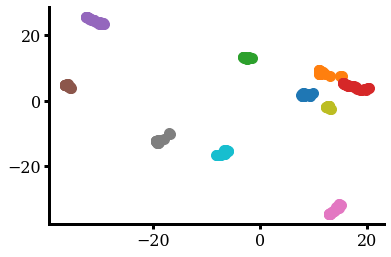

<Figure size 432x288 with 0 Axes>

In [358]:
for i in range(10):
    x = trace['ipos'][:,i,0]
    y = trace['ipos'][:,i,1]
    plt.plot(x, y, 'o--')
plt.figure()

In [359]:
# for i in range(10):
#     x = trace['ipos'][:,i,0] - trace['ipos'][0,i,0]
#     y = trace['ipos'][:,i,1] - trace['ipos'][0,i,1]
#     plt.plot(x, y, 'o--')

Text(0, 0.5, 'Weight')

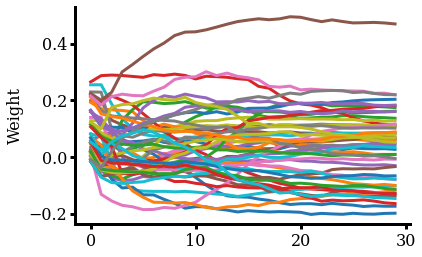

In [360]:
for i in range(10):
    plt.plot(trace['rw'][:,i,(i+1)%10])
    plt.plot(trace['rw'][:,i,(i+2)%10])
    plt.plot(trace['rw'][:,i,(i+3)%10])
    plt.plot(trace['rw'][:,i,(i+4)%10])
    plt.plot(trace['rw'][:,i,(i+5)%10])
plt.ylabel('Weight')

In [361]:
EPS = 0.4
import numpy as np
for i in range(100):
    plt.plot(100 * EPS * (0.5 + 0.5 * np.tanh(trace['ierr'][:,i])))
plt.ylabel('Epsilon (%)')
plt.xlabel('Epoch')

KeyError: 'ierr'


# Distance plot

In [362]:
trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        # 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

IndexError: list index out of range

In [32]:
import jax
import jax.numpy as jnp
def spatial_to_delay(r, from_=None):
    if from_ is not None:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((from_ - ri)**2).sum(axis=1)))(r)
        # d.shape is here (r.shape[0], from_.shape[0])
        d = d.flatten()
        return d
    else:
        d = jax.vmap(lambda ri: jnp.sqrt(1e-2+((r - ri)**2).sum(axis=1)))(r)
        d = diagonal_const(d, 1000000)
        d = d.flatten()
        return d
    
    

def diagonal_const(arr, c):
    n = arr.shape[0]
    return arr * (1 - jnp.eye(n)) + jnp.eye(n) * c

X = trace['rw'][-1].flatten()

Y = spatial_to_delay(trace['rpos'][-1])

m = Y != Y.max()

print(X.shape)
print(Y.shape)

plt.scatter(Y[m], X[m])
plt.axhline(0)
plt.xlabel('Distance')
plt.ylabel('Weight')


TypeError: list indices must be integers or slices, not str

# E-I balance

''

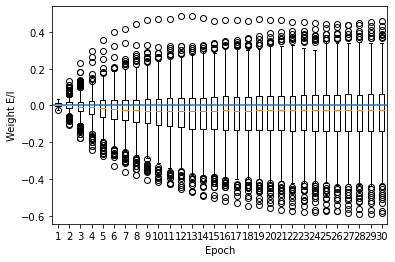

In [35]:

trace = [
    dict(np.load(x))
    for x in 
    sorted(x for x in glob.glob(
        'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
        # '/tmp/saved/20251106_d2e0.1_h10_lr0.1_ll10_dt0.5_2fc78afa-13fb-4f39-8fd8-11f21bf57256/epoch_*.npz'
        # '/tmp/saved/*3e1*/epoch_*.npz'
    ) if not 'read' in x)
]

columns = trace[0].keys()

trace = {
    k: np.array([x[k] for x in trace]) for k in columns
}

X = trace['rw']
X = X[:,~jnp.eye(X.shape[1], dtype=bool)]

plt.boxplot(X.T)
plt.axhline(0)
plt.xlabel('Epoch')
plt.ylabel('Weight E/I')
;

# YY

In [173]:
from io import StringIO


In [456]:
# 0 and Fixed Delays same param count
csv_data = '''0,1,2,3,4,5,6,7
neurons,10,15,20,25,30,45,60
nparams_0,70,105,140,175,210,315,420
nparams_inf,140,210,280,350,420,630,840
nparams_2d,104,149,194,239,284,419,554
nparams_3d,121,171,221,271,321,471,621
nparams_4d,138,193,248,303,358,523,688
t1p_0d,70.078125,68.535155,70.195315,71.40625,71.5625,81.45508000000001,79.71679499999999
t1p_fd,70.888675,80.29297,86.18163999999999,82.480465,81.2793,88.242185,90.6738275
t1p_inf,77.41211,82.421875,85.49805,86.93359,90.3125,90.634765,91.865235
t1p_2d,76.40625,78.515625,84.23828,85.283205,89.492185,90.75195,93.1445325
t1p_3d,68.99414,79.25781,80.99609,82.96875,88.22266,89.13086,90.4394525
t1p_4d,65.361328,74.56055,86.1132825,83.79883000000001,87.49023500000001,88.867185,90.839845
'''.strip()

df = pd.read_csv(StringIO(csv_data))
df = df.set_index('0', ).T
df

0,neurons,nparams_0,nparams_inf,nparams_2d,nparams_3d,nparams_4d,t1p_0d,t1p_fd,t1p_inf,t1p_2d,t1p_3d,t1p_4d
1,10.0,70.0,140.0,104.0,121.0,138.0,70.078125,70.888675,77.412110,76.406250,68.994140,65.361328
2,15.0,105.0,210.0,149.0,171.0,193.0,68.535155,80.292970,82.421875,78.515625,79.257810,74.560550
3,20.0,140.0,280.0,194.0,221.0,248.0,70.195315,86.181640,85.498050,84.238280,80.996090,86.113282
4,25.0,175.0,350.0,239.0,271.0,303.0,71.406250,82.480465,86.933590,85.283205,82.968750,83.798830
5,30.0,210.0,420.0,284.0,321.0,358.0,71.562500,81.279300,90.312500,89.492185,88.222660,87.490235
6,45.0,315.0,630.0,419.0,471.0,523.0,81.455080,88.242185,90.634765,90.751950,89.130860,88.867185
7,60.0,420.0,840.0,554.0,621.0,688.0,79.716795,90.673828,91.865235,93.144532,90.439453,90.839845


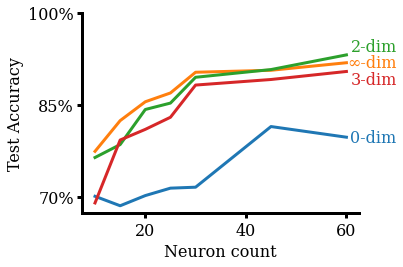

In [288]:

#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.neurons, df.t1p_0d),  '0-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_inf), '∞-dim', ha='right', va='center', dx=10)
label(plt.plot(df.neurons, df.t1p_2d),  '2-dim', ha='right', va='bottom', dx=10)
label(plt.plot(df.neurons, df.t1p_3d),  '3-dim', ha='right', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Neuron count')

plt.tight_layout()
plt.savefig('img/yy0.png')
plt.savefig('img/yy0.svg')


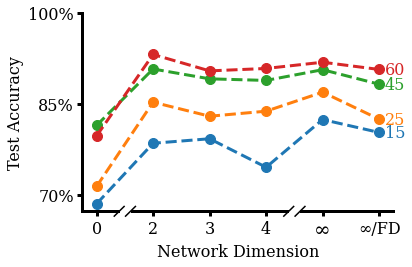

In [287]:
for nh in 15, 25, 45, 60:
    x = '0', '2', '3', '4', '∞', '∞/FD'
    y = df[['t1p_0d',  't1p_2d', 't1p_3d', 't1p_4d', 't1p_inf', 't1p_fd']][df.neurons == nh].values[0]
    line, = plt.plot(np.arange(len(x)), y, 'o--')
    plt.text(
        len(x)-1+.1,
        y[-1],
        f'{nh}',
        va='center',
        ha='left',
        color = line.get_color()
    )

ax = plt.gca()

ax.set_xticks(np.arange(len(x)))
text_labels = ax.set_xticklabels(x)
text_labels[-2].set_fontsize(20)
plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])

a = plt.ylim()

plt.gcf().canvas.draw()
y_data = ax.get_ylim()[0]

for x_positions in [
        [0.4, 0.6],
        [3.4, 3.6]
    ]:
    L_px = 15.0
    half = L_px / 2.0
    d = half / np.sqrt(2.0)
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    to_display = ax.transData.transform
    to_data = ax.transData.inverted().transform
    ax.plot([min(x_positions)+0.03, -0.03+max(x_positions)], [y_data, y_data], color='w', linewidth=3, clip_on=False, zorder=10)
    for x0 in x_positions:
        x_disp, y_disp = to_display((x0, y_data))
        p1_disp = (x_disp - d, y_disp - d)
        p2_disp = (x_disp + d, y_disp + d)
        p1_data = to_data(p1_disp)
        p2_data = to_data(p2_disp)
        ax.plot([p1_data[0], p2_data[0]], [p1_data[1], p2_data[1]],
                color='k', linewidth=1.5, clip_on=False, zorder=100)

plt.ylim(a)
plt.xlabel('Network Dimension')

plt.tight_layout()
plt.savefig('img/yy1.png')
plt.savefig('img/yy1.svg')

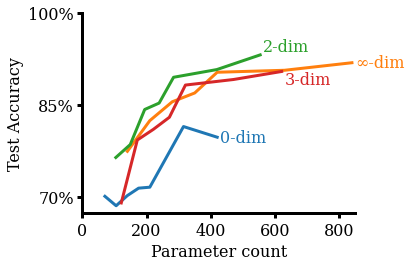

In [463]:
#spatial
#0	neurons	nparams_0	nparams_inf	nparams_2d	nparams_3d	nparams_4d	t1p_0d	t1p_fd	t1p_inf	t1p_2d	t1p_3d	t1p_4d


#plt.plot(df.neurons, df.t1p_fd)
label(plt.plot(df.nparams_0, df.t1p_0d),  '0-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_inf, df.t1p_inf), '∞-dim', ha='left', va='center', dx=10)
label(plt.plot(df.nparams_2d, df.t1p_2d),  '2-dim', ha='left', va='bottom', dx=10)
label(plt.plot(df.nparams_3d, df.t1p_3d),  '3-dim', ha='left', va='top',    dx=10)
#plt.plot(df.neurons, df.t1p_4d)

plt.ylabel('Test Accuracy')
plt.yticks([70, 85, 100], [f'{x}%' for x in [70, 85, 100]])
plt.xlabel('Parameter count')
plt.xlim(0, 850)

plt.tight_layout()
plt.savefig('img/yy0params.png')
plt.savefig('img/yy0params.svg')

# Grid

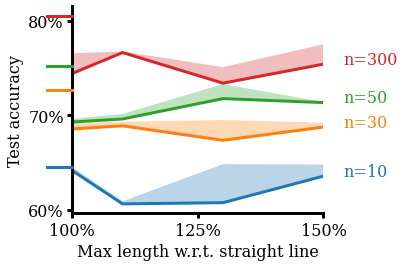

In [455]:
finaleps = (epoch[(epoch.i == 29) & (epoch.net.apply(lambda x: 'g' in x))]).copy()

finaleps['eps'] = finaleps['netspec'].str.split('g').str[1].astype(float)
finaleps = finaleps.loc[:, finaleps.nunique() > 1]
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
# print(finaleps.groupby(['nhidden', 'plotdim', 'eps']).count())
low = finaleps.groupby(['nhidden', 'eps']).quantile(0.5).reset_index().drop('seed', axis='columns')
high = finaleps.groupby(['nhidden', 'eps']).quantile(0.75).reset_index().drop('seed', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'eps']).median().reset_index().drop('seed', axis='columns')
#finaleps = finaleps[finaleps.nhidden == 10].groupby('net').median().sort_values('netspec')

# 10, 30, 50
#for n in [10, 30, 50]:

# display(finaleps)

for n in [10, 30, 50, 300]:
    X =finaleps[finaleps.nhidden == n]
    L =low[low.nhidden == n]
    H =high[high.nhidden == n]
    label(line := plt.plot(
        100+100*X.eps,
        X.t1p,
        '-'),
        f'n={n}', dx=4)
    plt.fill_between(
        100+100*X.eps.values,
        L.t1p.values,
        H.t1p.values, alpha=0.3, zorder=-100)
    reference = finalnormal[(finalnormal.net == str(2)) &(finalnormal.nhidden == n)].t1p.median()
    plt.plot(
        [95, 100], 
        [reference, reference],
        ls='-',
        color=line[0].get_color(),
        zorder=100,
        clip_on=False
    )
        
ml = np.array([100, 125, 150])
plt.xticks(ml, [f'{x}%' for x in ml])

#plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Max length w.r.t. straight line')

plt.yticks([60, 70, 80], [f'{x}%' for x in [60, 70, 80]])

plt.xlim(100, 150)

plt.tight_layout()
plt.savefig('img/grid.svg')
plt.savefig('img/grid.png')

In [393]:
epoch.net

0             2
1             2
2             2
3             2
4             2
          ...  
41236    2g0.30
41237    2g0.30
41238    2g0.30
41239    2g0.30
41240    2g0.30
Name: net, Length: 41241, dtype: object